In [9]:
from pipeline import GAL
from utils.dataset_wrapper import WrapperDataset
from sklearn.linear_model import LogisticRegression
from ref.ActiveLearning_OG import AL

data_object = WrapperDataset("wineQT.pkl")
dataset = data_object.dataset
input_dim = data_object.dim
output_dim = data_object.num_labels

print(dataset["available_pool_samples"].shape)

gal = GAL(dataset=dataset,
    classifier=LogisticRegression(),
    budget_per_iter=8,
    iterations=100,
    uncertainty_measures=["pagerank"],
    quantile=0.1,
    sim_metric="euclidean",
    use_gnn=True,
    gnn_epochs=5,
    input_dim=input_dim,
    gnn_hidden=32,
    output_dim=output_dim,
    plot=False,
    AL4GE=False,
    coef=None,
    n_clusters=4,)

res_gal = gal.run(plot=False)

selection_criteria = ['random', 'custom']
accuracy_scores_dict = {}
for criterion in selection_criteria:
	AL_class = AL(dataset=dataset,
			   selection_criterion=criterion,
			   iterations=100,
			   budget_per_iter=8,
			   train_limit=int(1e6),)
	accuracy_scores_dict[criterion] = AL_class.run_pipeline()

(800, 11)
SimpleGNN(
  (encoder_conv1): GCNConv(11, 16)
  (encoder_conv2): SAGEConv(16, 16, aggr=sum)
  (decoder): Classifier(
    (model): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=6, bias=True)
    )
    (softmax): Softmax(dim=-1)
  )
)


100%|██████████| 100/100 [00:06<00:00, 15.17it/s, GAL_Iteration=99, GAL_Accuracy=0.555, GAL_LR test acc=0.651, GNN Train Acc=0.685, GNN Test Acc=0.555]


Accuracy: 0.59
----------------------------------------
Accuracy: 0.607
----------------------------------------
Accuracy: 0.62
----------------------------------------
Accuracy: 0.598
----------------------------------------
Accuracy: 0.603
----------------------------------------
Accuracy: 0.603
----------------------------------------
Accuracy: 0.607
----------------------------------------
Accuracy: 0.62
----------------------------------------
Accuracy: 0.603
----------------------------------------
Accuracy: 0.59
----------------------------------------
Accuracy: 0.576
----------------------------------------
Accuracy: 0.59
----------------------------------------
Accuracy: 0.598
----------------------------------------
Accuracy: 0.594
----------------------------------------
Accuracy: 0.598
----------------------------------------
Accuracy: 0.607
----------------------------------------
Accuracy: 0.607
----------------------------------------
Accuracy: 0.62
---------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/results.csv")
df["dataset"] = df["dataset"].apply(lambda x: x.split(".")[0])
df["uncertainty_measures"] = df["uncertainty_measures"].apply(lambda x: "AGGR" if x not in ["area_variance", "pagerank", "density_kmean", "entropy_e", "AL4GE"] else x)
_dsts = set(df["dataset"])
df

,dataset,uncertainty_measures,AL4GE,GNN_avg,LR_avg,aggr_avg,custom_avg,random_avg
0,iris,AGGR,False,0.848,0.878,0.851,0.868,0.832
1,iris,area_variance,False,0.878,0.862,0.883,0.868,0.832
2,iris,pagerank,False,0.833,0.813,0.837,0.868,0.832
3,iris,density_kmean,False,0.854,0.860,0.854,0.868,0.832
4,iris,entropy_e,False,0.860,0.883,0.862,0.868,0.832
5,iris,AL4GE,True,0.862,0.879,0.871,0.868,0.832
6,wineQT,area_variance,False,0.520,0.589,0.521,0.588,0.603
7,wineQT,entropy_e,False,0.519,0.637,0.521,0.588,0.603
8,wineQT,pagerank,False,0.513,0.597,0.514,0.588,0.603
9,wineQT,density_kmean,False,0.511,0.621,0.515,0.588,0.603


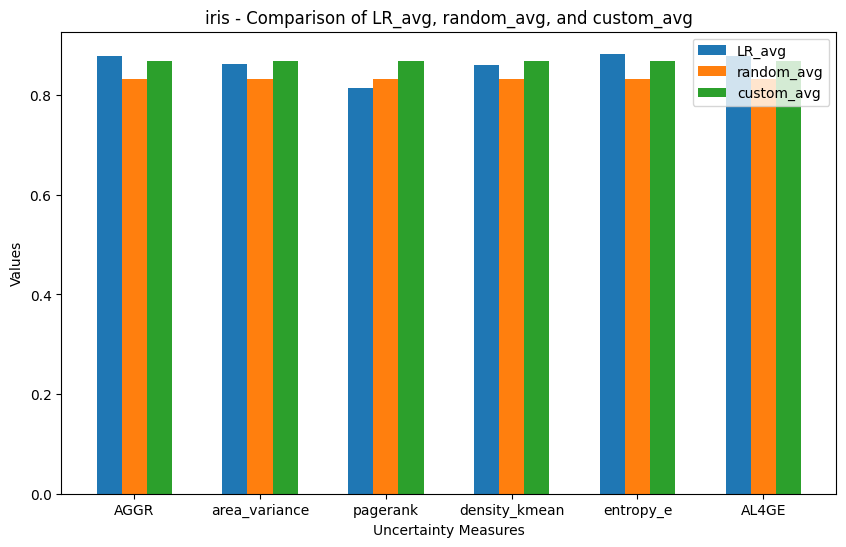

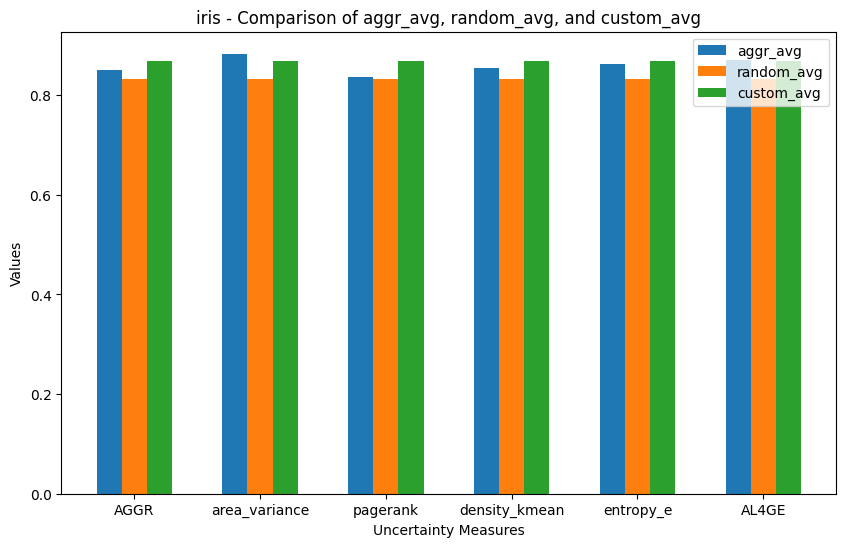

In [24]:
for dataset in df['dataset'].unique():
    # Filter data for the current dataset
    subset = df[df['dataset'] == dataset]
    
    # Set the width for bars and positions on x-axis
    bar_width = 0.2
    x = np.arange(len(subset))
    
    # Plot 1: LR_avg, random_avg, custom_avg
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width, subset['LR_avg'], width=bar_width, label='LR_avg')
    ax.bar(x, subset['random_avg'], width=bar_width, label='random_avg')
    ax.bar(x + bar_width, subset['custom_avg'], width=bar_width, label='custom_avg')
    
    ax.set_xticks(x)
    ax.set_xticklabels(subset['uncertainty_measures'])
    ax.set_xlabel('Uncertainty Measures')
    ax.set_ylabel('Values')
    ax.set_title(f'{dataset} - Comparison of LR_avg, random_avg, and custom_avg')
    ax.legend()
    plt.show()
    
    # Plot 2: aggr_avg, random_avg, custom_avg
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width, subset['aggr_avg'], width=bar_width, label='aggr_avg')
    ax.bar(x, subset['random_avg'], width=bar_width, label='random_avg')
    ax.bar(x + bar_width, subset['custom_avg'], width=bar_width, label='custom_avg')
    
    ax.set_xticks(x)
    ax.set_xticklabels(subset['uncertainty_measures'])
    ax.set_xlabel('Uncertainty Measures')
    ax.set_ylabel('Values')
    ax.set_title(f'{dataset} - Comparison of aggr_avg, random_avg, and custom_avg')
    ax.legend()
    plt.show()
    break

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_with_pca(data, labels, title):
    """
    Plots the dataset, applying PCA if necessary to reduce dimensionality to 2.

    Parameters:
    data (numpy.ndarray): The dataset matrix where rows are samples and columns are features.
    labels (array-like): Labels corresponding to each sample in the dataset.
    """
    # Check if dimensionality reduction is needed
    if data.shape[1] > 2:
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(data)
        print("PCA applied to reduce dimensions to 2.")
    else:
        data_2d = data
        print("Data already 2-dimensional, no PCA applied.")
    
    # Unique labels and color mapping
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("viridis", len(unique_labels))
    
    # Create scatter plot with legend for each label
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_labels):
        plt.scatter(data_2d[labels == label, 0], data_2d[labels == label, 1],
                    color=colors(i), label=f"Label {label}", alpha=0.7)
    
    plt.title(f"{title}")
    plt.legend(title="Labels")
    plt.savefig(f'./plots/{title}.png', format='png', dpi=300, bbox_inches='tight')
    
def wrapper(data_name):
    data = WrapperDataset(f"{data_name}.pkl").dataset

    X = np.concat([data["train_samples"], data["available_pool_samples"], data["test_samples"]])
    y = np.concat([data["train_labels"], data["available_pool_labels"], data["test_labels"]])
    plot_with_pca(X, y, title=data_name)
    

PCA applied to reduce dimensions to 2.


/var/folders/9f/_6775r3x22z0p4kb6_fn2xmr0000gn/T/ipykernel_8326/4002371328.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_labels))


PCA applied to reduce dimensions to 2.


/var/folders/9f/_6775r3x22z0p4kb6_fn2xmr0000gn/T/ipykernel_8326/4002371328.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_labels))


PCA applied to reduce dimensions to 2.


/var/folders/9f/_6775r3x22z0p4kb6_fn2xmr0000gn/T/ipykernel_8326/4002371328.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_labels))


Data already 2-dimensional, no PCA applied.
Data already 2-dimensional, no PCA applied.


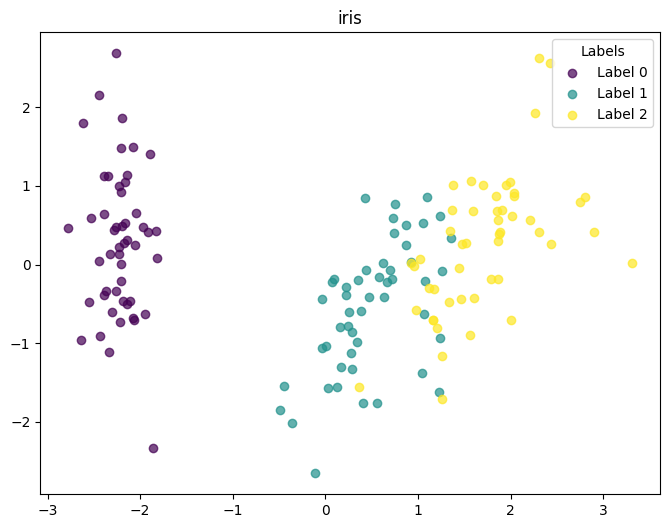

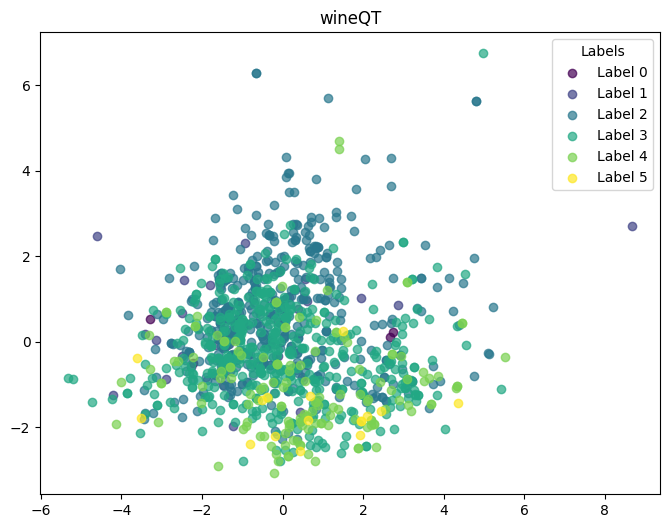

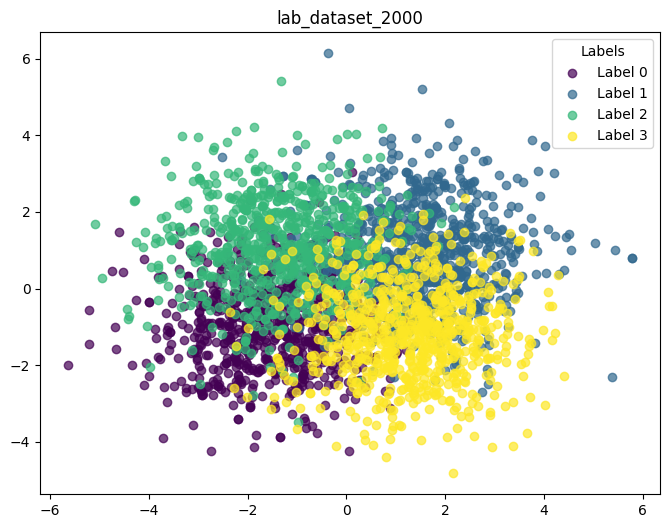

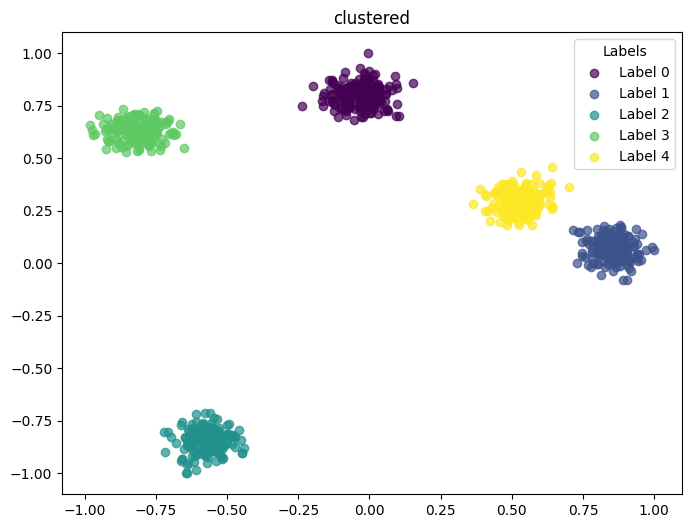

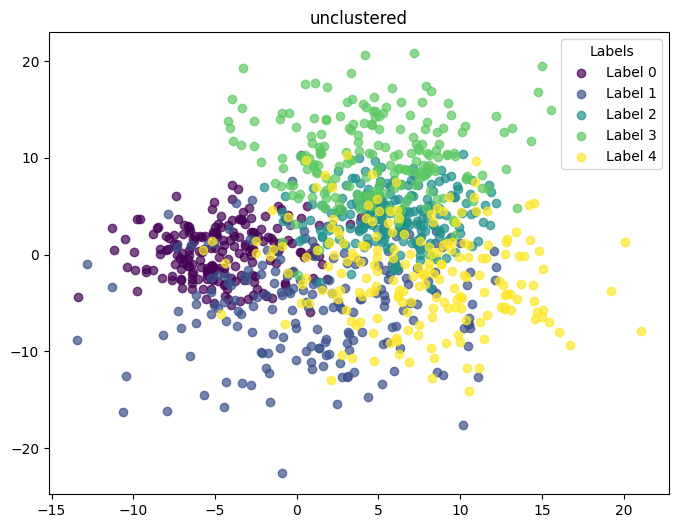

In [55]:
d

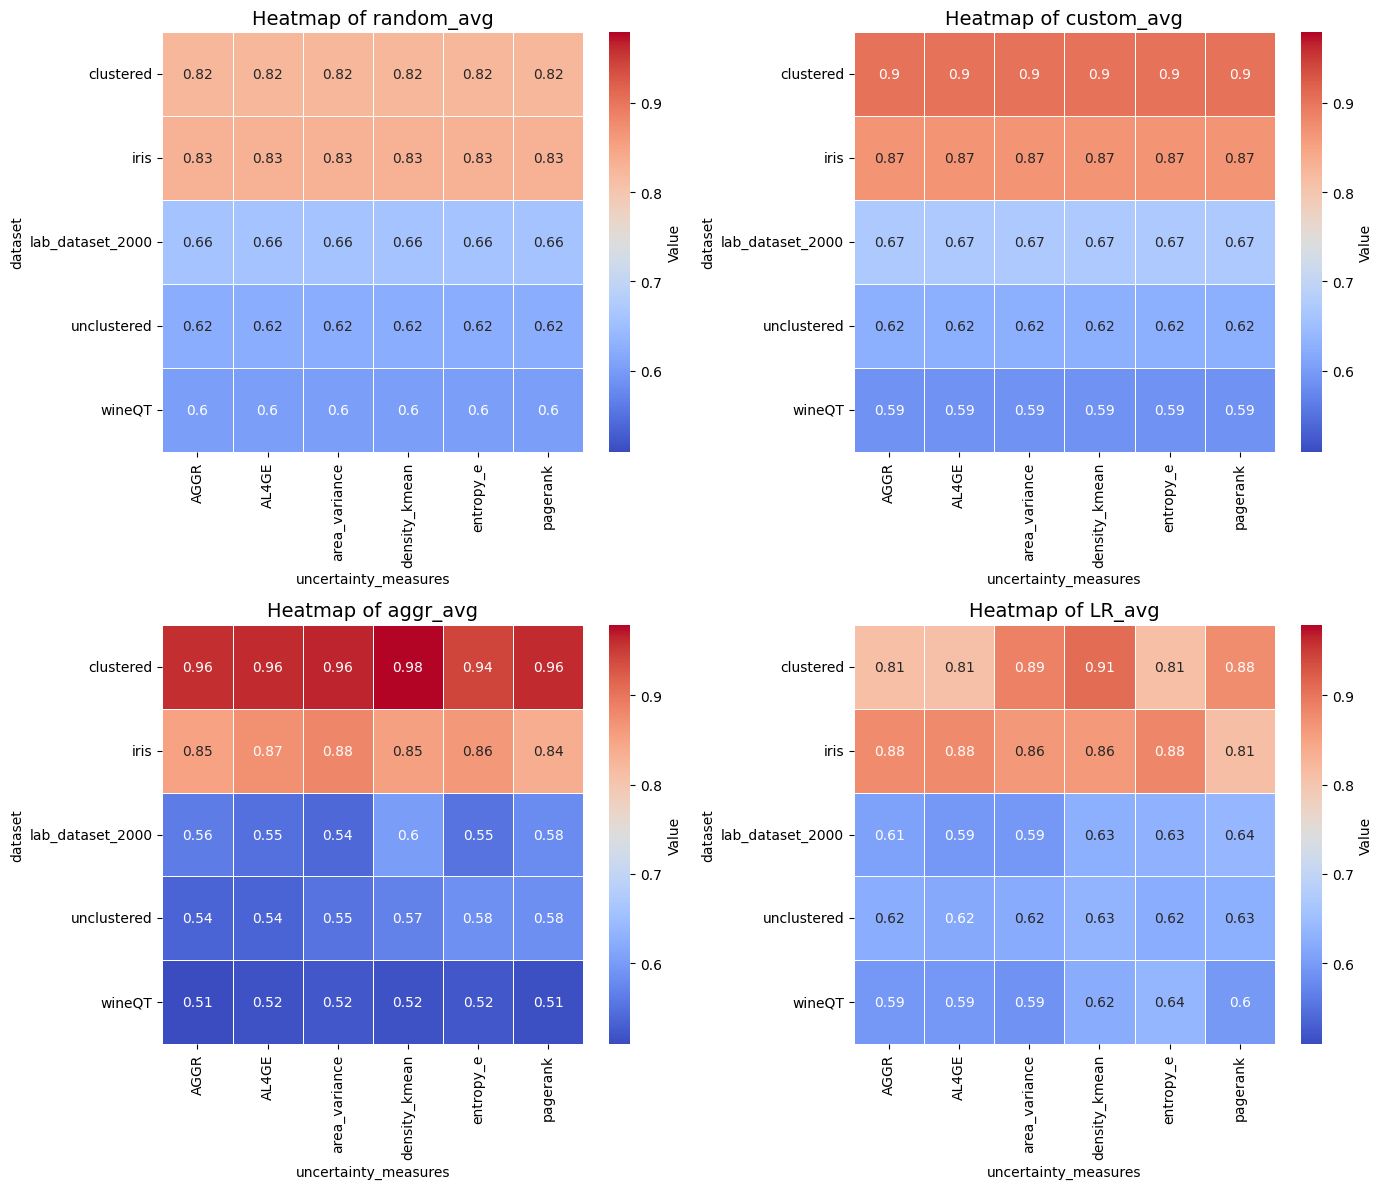

In [6]:
# Pivoting the data for heatmaps
import seaborn as sns
heatmap_aggr = df.pivot(index='dataset', columns='uncertainty_measures', values='aggr_avg')
heatmap_LR = df.pivot(index='dataset', columns='uncertainty_measures', values='LR_avg')
heatmap_random = df.pivot(index='dataset', columns='uncertainty_measures', values='random_avg')
heatmap_custom = df.pivot(index='dataset', columns='uncertainty_measures', values='custom_avg')

# Setting the common color scale range
vmin, vmax = df[['aggr_avg', 'LR_avg', 'random_avg', 'custom_avg']].min().min(), df[['aggr_avg', 'LR_avg', 'random_avg', 'custom_avg']].max().max()

# Setting up the figure
plt.figure(figsize=(14, 12))

# Plotting the first heatmap (aggr_avg)
plt.subplot(2, 2, 3)
sns.heatmap(heatmap_aggr, annot=True, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, annot_kws={'size': 10}, linewidths=0.5)
plt.title('Heatmap of aggr_avg', fontsize=14)

# Plotting the second heatmap (LR_avg)
plt.subplot(2, 2, 4)
sns.heatmap(heatmap_LR, annot=True, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, annot_kws={'size': 10}, linewidths=0.5)
plt.title('Heatmap of LR_avg', fontsize=14)

# Plotting the third heatmap (random_avg)
plt.subplot(2, 2, 1)
sns.heatmap(heatmap_random, annot=True, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, annot_kws={'size': 10}, linewidths=0.5)
plt.title('Heatmap of random_avg', fontsize=14)

# Plotting the fourth heatmap (custom_avg)
plt.subplot(2, 2, 2)
sns.heatmap(heatmap_custom, annot=True, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, annot_kws={'size': 10}, linewidths=0.5)
plt.title('Heatmap of custom_avg', fontsize=14)

# Adjust layout for better visualization
plt.tight_layout()
plt.savefig(f'./plots/heatmaps.png', format='png', dpi=300, bbox_inches='tight')

/var/folders/9f/_6775r3x22z0p4kb6_fn2xmr0000gn/T/ipykernel_8326/1241197425.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


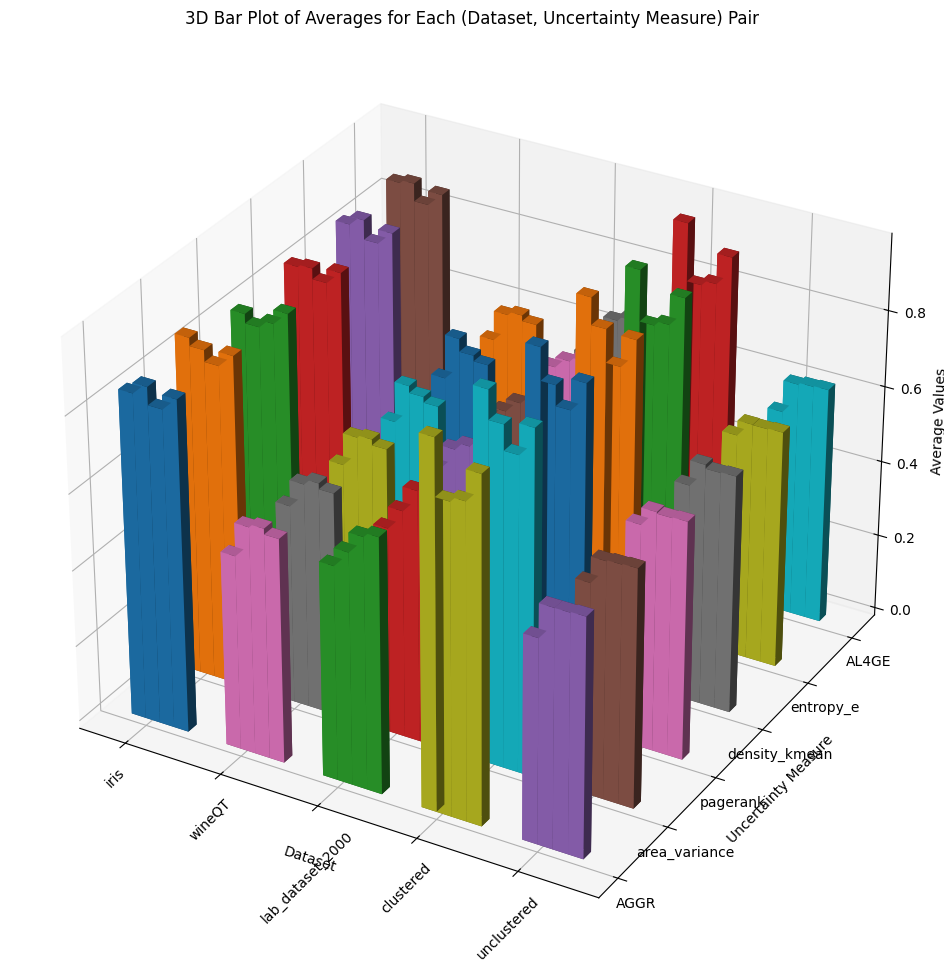

In [64]:
datasets = df['dataset'].unique()
uncertainty_measures = df['uncertainty_measures'].unique()

# Set up the 3D plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Define width of the bars and shift for each of the 4 averages
dx = dy = 0.15  # Bar width
x_pos_offset = np.array([0, 1, 2, 3]) * dx  # Offsets for the 4 bars

# Plot each (dataset, uncertainty_measure) pair with 4 bars for each average
for i, dataset in enumerate(datasets):
    for j, uncertainty in enumerate(uncertainty_measures):
        # Get the corresponding values for the 4 averages
        values = df[(df['dataset'] == dataset) & (df['uncertainty_measures'] == uncertainty)][['aggr_avg', 'LR_avg', 'random_avg', 'custom_avg']].values.flatten()
        
        # X positions for the bars
        x_pos = i + x_pos_offset
        
        # Y position for the bars (uncertainty measure index)
        y_pos = np.full_like(x_pos, j)
        
        # Z positions for the bars (starting height)
        z_pos = np.zeros_like(x_pos)
        
        # Heights of the bars
        dz = values
        
        # Create the 3D bars
        ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)

# Set labels and titles
ax.set_xlabel('Dataset')
ax.set_ylabel('Uncertainty Measure')
ax.set_zlabel('Average Values')
ax.set_xticks(np.arange(len(datasets)) + 0.15)  # Slight offset for better alignment
ax.set_xticklabels(datasets, rotation=45)
ax.set_yticks(np.arange(len(uncertainty_measures)))
ax.set_yticklabels(uncertainty_measures)

# Set title
ax.set_title('3D Bar Plot of Averages for Each (Dataset, Uncertainty Measure) Pair')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()